# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=15,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 15)
OOV context shape: (16562, 28)
Right context shape: (16562, 15)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[ 1.8663413e+17,  4.5763605e-41,  1.8663413e+17, ...,
         4.5762204e-41, -1.2623962e+08,  4.5762204e-41],
       [ 9.3411957e-41,  0.0000000e+00, -8.8393088e+07, ...,
         0.0000000e+00, -8.8395648e+07,  4.5762204e-41],
       [-1.2624525e+08,  4.5762204e-41,  9.3427371e-41, ...,
         4.5762204e-41,  9.3441384e-41,  0.0000000e+00],
       ...,
       [-1.2692160e+08,  4.5762204e-41,  9.5159376e-41, ...,
         4.5762204e-41,  9.5173389e-41,  0.0000000e+00],
       [-9.4544800e+06,  4.5762204e-41, -1.2692723e+08, ...,
         4.5762204e-41, -1.2693235e+08,  4.5762204e-41],
       [ 9.5188803e-41,  0.0000000e+00, -9.4548320e+06, ...,
         0.0000000e+00, -9.4551520e+06,  4.5762204e-41]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=5.9828 | F1Score=0.2744
Batch-100: NLLLoss=4.5442 | F1Score=0.2906
Batch-150: NLLLoss=5.1247 | F1Score=0.3084
Batch-200: NLLLoss=4.7580 | F1Score=0.3352
Batch-250: NLLLoss=2.9342 | F1Score=0.3540
Batch-300: NLLLoss=4.2674 | F1Score=0.3741
Batch-350: NLLLoss=4.1455 | F1Score=0.3904
Batch-400: NLLLoss=3.1451 | F1Score=0.4056
Batch-450: NLLLoss=4.3019 | F1Score=0.4200
Batch-500: NLLLoss=3.2857 | F1Score=0.4322
Batch-518: NLLLoss=4.0384 | F1Score=0.4350

Mean NLLLoss: 4.5228 | Mean F1Score: 0.3487

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=3.0697 | F1Score=0.5944
Batch-100: NLLLoss=2.3977 | F1Score=0.6020
Batch-150: NLLLoss=3.0060 | F1Score=0.6071
Batch-200: NLLLoss=2.5795 | F1Score=0.6121
Batch-250: NLLLoss=2.5705 | F1Score=0.6170
Batch-300: NLLLoss=2.9766 | F1Score=0.6237
Batch-350: NLLLoss=1.9871 | F1Score=0.6276
Batch-400: NLLLoss=1.9546 | F1Score=0.6309
Batch-450: NLLLoss=1.8107 | F1Score=0.6350
Batch-500: NLLLoss=2.4928 | F1Score=0.6400
Batch-518: NLLLoss=3.0042 | F1Score=0.6415

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.6899 | Mean F1Score: 0.6188

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.6630 | F1Score=0.7277
Batch-100: NLLLoss=2.4170 | F1Score=0.7295
Batch-150: NLLLoss=1.3805 | F1Score=0.7330
Batch-200: NLLLoss=1.2598 | F1Score=0.7354
Batch-250: NLLLoss=2.2348 | F1Score=0.7384
Batch-300: NLLLoss=2.5978 | F1Score=0.7402
Batch-350: NLLLoss=1.4772 | F1Score=0.7420
Batch-400: NLLLoss=1.4521 | F1Score=0.7426
Batch-450: NLLLoss=1.3910 | F1Score=0.7444
Batch-500: NLLLoss=2.7551 | F1Score=0.7465
Batch-518: NLLLoss=2.8046 | F1Score=0.7471

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7774 | Mean F1Score: 0.7373

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.7845 | F1Score=0.7981
Batch-100: NLLLoss=1.4171 | F1Score=0.8076
Batch-150: NLLLoss=0.9111 | F1Score=0.8045
Batch-200: NLLLoss=0.6291 | F1Score=0.8057
Batch-250: NLLLoss=0.6303 | F1Score=0.8076
Batch-300: NLLLoss=1.2219 | F1Score=0.8090
Batch-350: NLLLoss=1.3499 | F1Score=0.8123
Batch-400: NLLLoss=0.5033 | F1Score=0.8151
Batch-450: NLLLoss=0.7472 | F1Score=0.8153
Batch-500: NLLLoss=0.7495 | F1Score=0.8154
Batch-518: NLLLoss=1.0565 | F1Score=0.8166

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1586 | Mean F1Score: 0.8073

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.6324 | F1Score=0.9031
Batch-100: NLLLoss=0.6336 | F1Score=0.8945
Batch-150: NLLLoss=0.4886 | F1Score=0.8901
Batch-200: NLLLoss=0.8198 | F1Score=0.8848
Batch-250: NLLLoss=0.5416 | F1Score=0.8806
Batch-300: NLLLoss=0.7762 | F1Score=0.8770
Batch-350: NLLLoss=0.9847 | F1Score=0.8751
Batch-400: NLLLoss=0.4666 | F1Score=0.8722
Batch-450: NLLLoss=0.4298 | F1Score=0.8707
Batch-500: NLLLoss=1.2016 | F1Score=0.8714
Batch-518: NLLLoss=0.5875 | F1Score=0.8717

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.6884 | Mean F1Score: 0.8827

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2179 | F1Score=0.9603
Batch-100: NLLLoss=0.4363 | F1Score=0.9580
Batch-150: NLLLoss=0.2633 | F1Score=0.9574
Batch-200: NLLLoss=0.3602 | F1Score=0.9551
Batch-250: NLLLoss=0.2141 | F1Score=0.9504
Batch-300: NLLLoss=0.3564 | F1Score=0.9503
Batch-350: NLLLoss=0.2104 | F1Score=0.9467
Batch-400: NLLLoss=0.6490 | F1Score=0.9434
Batch-450: NLLLoss=0.4592 | F1Score=0.9428
Batch-500: NLLLoss=0.4061 | F1Score=0.9413
Batch-518: NLLLoss=0.0977 | F1Score=0.9406

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3265 | Mean F1Score: 0.9512

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0616 | F1Score=0.9912
Batch-100: NLLLoss=0.2074 | F1Score=0.9912
Batch-150: NLLLoss=0.0132 | F1Score=0.9929
Batch-200: NLLLoss=0.0785 | F1Score=0.9927
Batch-250: NLLLoss=0.0512 | F1Score=0.9936
Batch-300: NLLLoss=0.0945 | F1Score=0.9929
Batch-350: NLLLoss=0.1795 | F1Score=0.9915
Batch-400: NLLLoss=0.1385 | F1Score=0.9907
Batch-450: NLLLoss=0.2021 | F1Score=0.9899
Batch-500: NLLLoss=0.1009 | F1Score=0.9895
Batch-518: NLLLoss=0.1410 | F1Score=0.9893

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1057 | Mean F1Score: 0.9915

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0159 | F1Score=0.9994
Batch-100: NLLLoss=0.0199 | F1Score=0.9978
Batch-150: NLLLoss=0.0161 | F1Score=0.9981
Batch-200: NLLLoss=0.0220 | F1Score=0.9983
Batch-250: NLLLoss=0.0302 | F1Score=0.9979
Batch-300: NLLLoss=0.0137 | F1Score=0.9982
Batch-350: NLLLoss=0.0320 | F1Score=0.9983
Batch-400: NLLLoss=0.0363 | F1Score=0.9984
Batch-450: NLLLoss=0.0252 | F1Score=0.9982
Batch-500: NLLLoss=0.0258 | F1Score=0.9982
Batch-518: NLLLoss=0.0637 | F1Score=0.9981

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0332 | Mean F1Score: 0.9983

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0038 | F1Score=0.9987
Batch-100: NLLLoss=0.0181 | F1Score=0.9991
Batch-150: NLLLoss=0.0130 | F1Score=0.9992
Batch-200: NLLLoss=0.0160 | F1Score=0.9989
Batch-250: NLLLoss=0.0163 | F1Score=0.9986
Batch-300: NLLLoss=0.0077 | F1Score=0.9987
Batch-350: NLLLoss=0.0078 | F1Score=0.9986
Batch-400: NLLLoss=0.0160 | F1Score=0.9987
Batch-450: NLLLoss=0.0053 | F1Score=0.9989
Batch-500: NLLLoss=0.0068 | F1Score=0.9989
Batch-518: NLLLoss=0.0011 | F1Score=0.9990

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0138 | Mean F1Score: 0.9988

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0054 | F1Score=1.0000
Batch-100: NLLLoss=0.0047 | F1Score=0.9992
Batch-150: NLLLoss=0.0041 | F1Score=0.9995
Batch-200: NLLLoss=0.0051 | F1Score=0.9993
Batch-250: NLLLoss=0.0083 | F1Score=0.9994
Batch-300: NLLLoss=0.0069 | F1Score=0.9995
Batch-350: NLLLoss=0.0033 | F1Score=0.9995
Batch-400: NLLLoss=0.0037 | F1Score=0.9996
Batch-450: NLLLoss=0.0054 | F1Score=0.9996
Batch-500: NLLLoss=0.0065 | F1Score=0.9996
Batch-518: NLLLoss=0.0017 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0066 | Mean F1Score: 0.9995

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0034 | F1Score=0.9994
Batch-100: NLLLoss=0.0039 | F1Score=0.9997
Batch-150: NLLLoss=0.0029 | F1Score=0.9995
Batch-200: NLLLoss=0.0158 | F1Score=0.9993
Batch-250: NLLLoss=0.0025 | F1Score=0.9994
Batch-300: NLLLoss=0.0033 | F1Score=0.9995
Batch-350: NLLLoss=0.0031 | F1Score=0.9996
Batch-400: NLLLoss=0.0059 | F1Score=0.9996
Batch-450: NLLLoss=0.0037 | F1Score=0.9997
Batch-500: NLLLoss=0.0036 | F1Score=0.9996
Batch-518: NLLLoss=0.0038 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0046 | Mean F1Score: 0.9994

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0024 | F1Score=1.0000
Batch-100: NLLLoss=0.0029 | F1Score=1.0000
Batch-150: NLLLoss=0.0017 | F1Score=0.9996
Batch-200: NLLLoss=0.0036 | F1Score=0.9997
Batch-250: NLLLoss=0.0040 | F1Score=0.9997
Batch-300: NLLLoss=0.0034 | F1Score=0.9997
Batch-350: NLLLoss=0.0057 | F1Score=0.9996
Batch-400: NLLLoss=0.0026 | F1Score=0.9996
Batch-450: NLLLoss=0.0038 | F1Score=0.9997
Batch-500: NLLLoss=0.0037 | F1Score=0.9996
Batch-518: NLLLoss=0.0019 | F1Score=0.9996

Huft 😥! Model not improved.
Mean NLLLoss: 0.0055 | Mean F1Score: 0.9997
Patience = 1/20❗

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0030 | F1Score=0.9997
Batch-100: NLLLoss=0.0013 | F1Score=0.9998
Batch-150: NLLLoss=0.0018 | F1Score=0.9999
Batch-200: NLLLoss=0.0016 | F1Score=0.9999
Batch-250: NLLLoss=0.0018 | F1Score=0.9999
Batch-300: NLLLoss=0.0075 | F1Score=0.9997
Batch-350: NLLLoss=0.0110 | F1Score=0.9996
Batch-400: NLLLoss=0.6417 | F1Score=0.9935
Batch-450: NLLLoss=0.3823 | F1Score=0.9784
Batch-500: NLLLoss=0.7328 | F1Score=0.9684
Batch-518: NLLLoss=0.6543 | F1Score=0.9667

Huft 😥! Model not improved.
Mean NLLLoss: 0.1371 | Mean F1Score: 0.9945
Patience = 2/20❗

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1842 | F1Score=0.9488
Batch-100: NLLLoss=0.1857 | F1Score=0.9497
Batch-150: NLLLoss=0.2385 | F1Score=0.9499
Batch-200: NLLLoss=0.2774 | F1Score=0.9516
Batch-250: NLLLoss=0.1956 | F1Score=0.9538
Batch-300: NLLLoss=0.1474 | F1Score=0.9549
Batch-350: NLLLoss=0.2771 | F1Score=0.9553
Batch-400: NLLLoss=0.1062 | F1Score=0.9571
Batch-450: NLLLoss=0.1675 | F1Score=0.9590
Batch-500: NLLLoss=0.0458 | F1Score=0.9606
Batch-518: NLLLoss=0.2062 | F1Score=0.9612

Huft 😥! Model not improved.
Mean NLLLoss: 0.1562 | Mean F1Score: 0.9542
Patience = 3/20❗

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0136 | F1Score=0.9969
Batch-100: NLLLoss=0.0147 | F1Score=0.9981
Batch-150: NLLLoss=0.0190 | F1Score=0.9979
Batch-200: NLLLoss=0.0047 | F1Score=0.9978
Batch-250: NLLLoss=0.0043 | F1Score=0.9981
Batch-300: NLLLoss=0.0031 | F1Score=0.9982
Batch-350: NLLLoss=0.0093 | F1Score=0.9983
Batch-400: NLLLoss=0.0068 | F1Score=0.9984
Batch-450: NLLLoss=0.0636 | F1Score=0.9985
Batch-500: NLLLoss=0.0044 | F1Score=0.9985
Batch-518: NLLLoss=0.0022 | F1Score=0.9986

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0123 | Mean F1Score: 0.9981

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0013 | F1Score=0.9994
Batch-100: NLLLoss=0.0044 | F1Score=0.9997
Batch-150: NLLLoss=0.0205 | F1Score=0.9998
Batch-200: NLLLoss=0.0050 | F1Score=0.9998
Batch-250: NLLLoss=0.0008 | F1Score=0.9999
Batch-300: NLLLoss=0.0008 | F1Score=0.9999
Batch-350: NLLLoss=0.0087 | F1Score=0.9998
Batch-400: NLLLoss=0.0012 | F1Score=0.9998
Batch-450: NLLLoss=0.0020 | F1Score=0.9999
Batch-500: NLLLoss=0.0016 | F1Score=0.9999
Batch-518: NLLLoss=0.0024 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0020 | Mean F1Score: 0.9998

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0015 | F1Score=1.0000
Batch-100: NLLLoss=0.0017 | F1Score=1.0000
Batch-150: NLLLoss=0.0010 | F1Score=1.0000
Batch-200: NLLLoss=0.0006 | F1Score=1.0000
Batch-250: NLLLoss=0.0011 | F1Score=1.0000
Batch-300: NLLLoss=0.0012 | F1Score=0.9999
Batch-350: NLLLoss=0.0012 | F1Score=1.0000
Batch-400: NLLLoss=0.0019 | F1Score=1.0000
Batch-450: NLLLoss=0.0009 | F1Score=0.9998
Batch-500: NLLLoss=0.0006 | F1Score=0.9998
Batch-518: NLLLoss=0.0009 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0016 | Mean F1Score: 1.0000

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0010 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=0.9998
Batch-150: NLLLoss=0.0010 | F1Score=0.9999
Batch-200: NLLLoss=0.0015 | F1Score=0.9999
Batch-250: NLLLoss=0.0011 | F1Score=0.9998
Batch-300: NLLLoss=0.0006 | F1Score=0.9998
Batch-350: NLLLoss=0.0009 | F1Score=0.9999
Batch-400: NLLLoss=0.0007 | F1Score=0.9999
Batch-450: NLLLoss=0.0016 | F1Score=0.9999
Batch-500: NLLLoss=0.0012 | F1Score=0.9999
Batch-518: NLLLoss=0.0007 | F1Score=0.9999

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0012 | Mean F1Score: 0.9999

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0007 | F1Score=1.0000
Batch-100: NLLLoss=0.0009 | F1Score=0.9997
Batch-150: NLLLoss=0.0010 | F1Score=0.9998
Batch-200: NLLLoss=0.0006 | F1Score=0.9998
Batch-250: NLLLoss=0.0007 | F1Score=0.9999
Batch-300: NLLLoss=0.0008 | F1Score=0.9999
Batch-350: NLLLoss=0.0021 | F1Score=0.9997
Batch-400: NLLLoss=0.0013 | F1Score=0.9997
Batch-450: NLLLoss=0.0011 | F1Score=0.9998
Batch-500: NLLLoss=0.0014 | F1Score=0.9997
Batch-518: NLLLoss=0.0016 | F1Score=0.9997

Huft 😥! Model not improved.
Mean NLLLoss: 0.0013 | Mean F1Score: 0.9998
Patience = 4/20❗

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0005 | F1Score=0.9997
Batch-100: NLLLoss=0.0016 | F1Score=0.9994
Batch-150: NLLLoss=0.0008 | F1Score=0.9994
Batch-200: NLLLoss=0.0013 | F1Score=0.9995
Batch-250: NLLLoss=0.0006 | F1Score=0.9995
Batch-300: NLLLoss=0.0017 | F1Score=0.9995
Batch-350: NLLLoss=0.0024 | F1Score=0.9996
Batch-400: NLLLoss=0.0005 | F1Score=0.9996
Batch-450: NLLLoss=0.0009 | F1Score=0.9997
Batch-500: NLLLoss=0.0011 | F1Score=0.9996
Batch-518: NLLLoss=0.0027 | F1Score=0.9995

Huft 😥! Model not improved.
Mean NLLLoss: 0.0035 | Mean F1Score: 0.9996
Patience = 5/20❗

TRAINING SUMMARY
Best NLLLoss      : 0.0012
Best F1Score      : 0.9999
Training duration : 21.721 minutes.
Training date     : 2022-10-11 11:34:47.983464+08:00


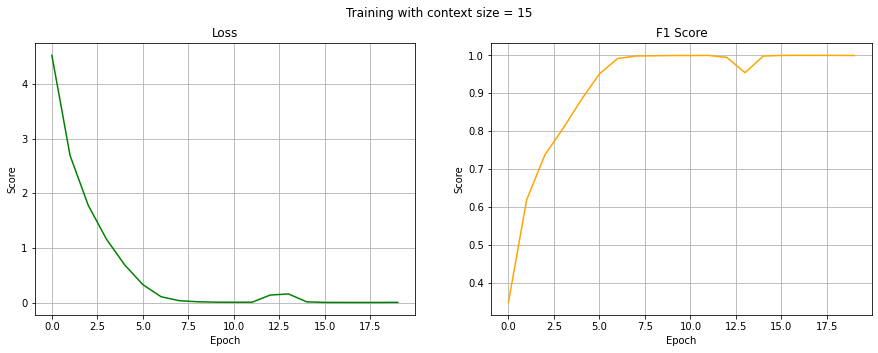

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 4.240182  , -2.58694   , -2.325591  , ...,  2.127207  ,
         2.9860823 ,  3.769742  ],
       [-0.19076535, -2.2472458 ,  6.5896807 , ...,  2.0483723 ,
         1.8878412 ,  0.38142273],
       [-3.202799  , -2.3245232 ,  5.219937  , ..., -0.09933946,
         0.6275703 , -0.5291314 ],
       ...,
       [ 0.86392426,  1.0079362 , -0.27138656, ..., -1.1736001 ,
        -5.03642   , -7.9797435 ],
       [ 1.8164444 , -0.9626991 , -5.253956  , ...,  4.703753  ,
        -1.7967918 , -1.1990857 ],
       [ 4.353201  , -0.5155281 ,  6.64803   , ...,  1.9702537 ,
        -2.6974626 ,  3.6210704 ]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[-0.1290, -0.0399,  0.4547,  ...,  0.1357,  0.0728, -0.4019],
                      [-0.0408,  0.4714, -0.2353,  ..., -0.1084, -0.0359, -0.4547],
                      [ 0.1179, -0.1528,  0.3386,  ..., -0.4945,  0.2738, -0.2103],
                      ...,
                      [ 0.2050, -0.1286,  0.0833,  ..., -0.1802, -0.0137, -0.2195],
                      [-0.0473, -0.0474,  0.0129,  ...,  0.1488, -0.1149, -0.0763],
                      [ 0.4812,  0.1022,  0.4288,  ...,  0.1392, -0.0710, -0.2928]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.2266, -0.1427,  0.0995,  ...,  0.2183,  0.0083, -0.1749],
                      [-0.0448, -0.2028, -0.0414,  ...,  0.1205, -0.0916,  0.0997],
                      [-0.0153, -0.1904, -0.0372,  ...,  0.0472, -0.3141, -0.0431],
                      ...,
                      [ 0.2459,  0.0664,  0.1019,  ..., -0.0975, -0.131